<a href="https://colab.research.google.com/github/juliaronquetti/Modelo_predicao_SP/blob/main/3_imoveis_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
start_time = time.time()

In [ ]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 100)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

path = 'https://github.com/juliaronquetti/Modelo_predicao_SP/'


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor, RANSACRegressor, TheilSenRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, make_scorer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold

from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error

import statsmodels.api as sm

In [ ]:
def error_metrics(y_true, y_pred):

  metrics = {}

  metrics['R2'] = np.round(r2_score(y_true, y_pred),2)
  metrics['RMSE'] = root_mean_squared_error(y_true, y_pred).round(2)
  metrics['MAE'] = mean_absolute_error(y_true, y_pred).round(2)
  metrics['MedAE'] = median_absolute_error(y_true, y_pred).round(2)
  metrics['MAPE'] = mean_absolute_percentage_error(y_true, y_pred).round(2)

  return metrics

In [ ]:
def cv_metrics(cv_results,grid_search):

  metrics = {}

  metrics['R2'] = cv_results['mean_test_R2'][grid_search.best_index_].round(2)
  metrics['RMSE'] = cv_results['mean_test_RMSE'][grid_search.best_index_].round(2)
  metrics['MAE'] = cv_results['mean_test_MAE'][grid_search.best_index_].round(2)
  metrics['MedAE'] = cv_results['mean_test_MedAE'][grid_search.best_index_].round(2)
  metrics['MAPE'] = cv_results['mean_test_MAPE'][grid_search.best_index_].round(2)

  return metrics

In [ ]:
from IPython.display import display, Latex, HTML
import warnings

def gera_df_stats_latex(df_stats, titulo):

  warnings.filterwarnings('ignore')
  # latex_table = df_stats.style.to_latex(hrules=True)
  latex_table = df_stats.to_latex(index=None)
  # display(Latex(latex_table))

  latex_table = latex_table.replace('tabular','array')
  latex_table = latex_table.replace('toprule','hline')
  latex_table = latex_table.replace('midrule','hline')
  latex_table = latex_table.replace('bottomrule','hline')

  latex_table = '\\textbf{' + titulo + '} \\\\' + latex_table

  warnings.filterwarnings('default')
  return latex_table

In [ ]:
def plot_results(y_true, y_pred, titulo, qmin=0, qmax=1, qqplot=True, title_result=True):
  import statsmodels.api as sm
  import scipy.stats as stats

  fig, ax = plt.subplots(2,2,figsize=(10,10))
  ax = ax.flatten()

  if title_result:
    erro = error_metrics(y_true, y_pred)['MAPE']
    plt.suptitle(titulo + f'\n Preços $\\pm$ {erro:.2f}%',fontsize=14,weight='bold')
  else:
    plt.suptitle(titulo,fontsize=14,weight='bold')

  lim_min = min(np.quantile(y_true, qmin),np.quantile(y_pred, qmin))
  lim_max = max(np.quantile(y_true, qmax),np.quantile(y_pred, qmax))
  ax[0].set_xlim([lim_min,lim_max])
  ax[0].set_ylim([lim_min,lim_max])

  ax[0].scatter(y_true, y_pred, alpha=0.2, s=10)
  ax[0].plot([lim_min, lim_max], [lim_min, lim_max], color='red', linestyle='--')
  ax[0].set_xlabel('Preços Reais $y$')
  ax[0].set_ylabel('Preços Previstos $y_{pred}$')
  ax[0].set_title('Preços Reais $y$ $\\times$ Preços Previstos $y_{pred}$',weight='bold')
  # Adicione um quadro com as métricas de erro
  metrics_text = '\n'.join([f"{key}: {value}" for key, value in error_metrics(y_true, y_pred).items()])
  ax[0].text(ax[0].get_xlim()[1]*0.08, ax[0].get_ylim()[1]*0.7, metrics_text, fontsize=10)

  ax[1].scatter(y_true, y_true - y_pred, alpha=0.2, s=10)
  ax[1].axhline(y=0, color='r', linestyle='--')
  ax[1].set_xlabel('Instâncias')
  ax[1].set_ylabel('Erro')
  ax[1].set_title('Erro $(y - y_{pred})$',weight='bold')

  sns.kdeplot(x = y_true - y_pred, alpha=0.2, ax=ax[2], color='blue',fill='blue')
  ax[2].set_xlabel('Erro')
  ax[2].set_ylabel('Freq')
  ax[2].set_title('Distribuição do Erro',weight='bold')

  if qqplot:
    # QQ plot for residuals
    stats.probplot(y_true - y_pred, dist="norm", plot=ax[3])
    ax[3].set_title('QQ Plot dos Resíduos',weight='bold')
  else:
    ax[3].scatter(y, np.abs((y_true - y_pred)) / y_true, alpha=0.2, s=10)
    ax[3].axhline(y=0, color='r', linestyle='--')
    ax[3].set_xlabel('Instâncias')
    ax[3].set_ylabel('MAPE')
    ax[3].set_title('MAPE $abs(y - y_{pred})/y$',weight='bold')

  plt.tight_layout()
  plt.show()

# Data

In [ ]:
df = pd.read_csv(path + 'imoveis_clean_encoded.csv')

# if you want test with few records
# np.random.seed(42)
# df = df.iloc[ np.random.choice(df.index, size=1000, replace=False) ]

# selecionar a zona
# df = df[ df.zona_SUL == 1 ].reset_index(drop=True)
# df.drop(columns=['zona_LESTE','zona_NORTE','zona_OESTE','zona_SUL'])

# selecionar quartos
# df = df[ df.quartos == 3 ].reset_index(drop=True)
# df.drop(columns=['quartos'])

df.head()

,title,price,location,destaque,condominio,area_util,quartos,banheiros,vagas_na_garagem,iptu,academia,elevador,permitido_animais,piscina,portaria,salao_de_festas,condominio_fechado,seguranca_24h,portao_eletronico,area_murada,area_de_servico,armarios_na_cozinha,armarios_no_quarto,churrasqueira,mobiliado,quarto_de_servico,ar_condicionado,porteiro_24h,varanda,img_index,categoria_Casas,tipo_Casa de vila,tipo_Cobertura,tipo_Duplex ou triplex,tipo_Kitnet,tipo_Loft,tipo_Padrão,zona_LESTE,zona_NORTE,zona_OESTE,zona_SUL
0,Apartamento MOBILIADO com ÓTIMA Localização Ág...,350000,859,1,380,43,2,1,0,0,1,1,1,0,1,1,1,1,0,0,1,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0
1,"Apartamento 115.000,00",115000,454,1,150,50,2,1,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,1,0
2,Casa de condomínio sobrado para venda com 97 m...,570000,328,0,320,97,3,3,2,19,0,0,1,1,0,0,1,0,1,0,1,1,1,0,0,0,1,1,0,4,1,0,0,0,0,0,0,0,0,1,0
3,"Cobertura com 3 dormitórios (1 suíte) á venda,...",2250000,2,0,1790,163,3,4,3,616,1,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,5,0,0,1,0,0,0,0,0,0,1,0
4,CASA TERREA NO JARDIM BONFIGLIOLI COM 3 DORMI...,820000,150,0,0,167,3,3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,1,0,0,0,0,0,1,0,0,1,0


# Start results history

In [ ]:
%%time
results_dict = {} # starts results history empty

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.3 µs


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Linear Regression: Numeric

In [ ]:
%%time
model_test_name = 'Linear Regression, all coefs'

df_model = df.copy()
df_model.drop(['title','img_index'], axis=1, inplace=True)
df_model = sm.add_constant(df_model)

results = sm.OLS(df_model['price'], df_model.drop(['price'],axis=1)).fit()

print(results.summary())

y_true = df_model['price']
y_pred = results.predict()

print()
results_dict[model_test_name + ' (all)'] = error_metrics(y_true, y_pred)

# exibe resultados
results_df = pd.DataFrame.from_dict(results_dict, orient='index', columns=['R2', 'RMSE', 'MAE', 'MedAE', 'MAPE'])
display(results_df.reset_index().rename(columns={'index':'Model'}).style.set_properties(**{'text-align': 'left'}).format({
    'R2': "{:.2f}",
    'RMSE': "{:.2f}",
    'MAE': "{:.2f}",
    'MedAE': "{:.2f}",
    'MAPE': "{:.2f}"
}))

print()

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     1093.
Date:                Sun, 20 Oct 2024   Prob (F-statistic):               0.00
Time:                        15:10:21   Log-Likelihood:            -2.7285e+05
No. Observations:               19151   AIC:                         5.458e+05
Df Residuals:                   19112   BIC:                         5.461e+05
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   2.87

,Model,R2,RMSE,MAE,MedAE,MAPE
0,"Linear Regression, all coefs (all)",0.68,372598.11,270493.26,200519.62,0.34



CPU times: user 182 ms, sys: 75.6 ms, total: 257 ms
Wall time: 156 ms


## Significant Coefs

In [ ]:
def get_features_to_remove(results, p_value_threshold=0.05):

  # Seleciona os coeficientes com p-value maior que 0.05
  coef_pvalues = results.pvalues[results.pvalues > p_value_threshold]

  # Imprime os coeficientes selecionados
  print("Coeficientes com p-value maior que 0.05:")
  print(coef_pvalues)

  features_pvalue_high = list(coef_pvalues.index)
  features_to_remove = []

  for feature in features_pvalue_high:
    if (not feature.startswith('tipo_')) and (not feature.startswith('zona_')): # features compostas, ou removemos todas ou nenhuma
      features_to_remove.append(feature)

  print()
  print('Features to remove: ', features_to_remove)

  return features_to_remove

_ = get_features_to_remove(results)


Coeficientes com p-value maior que 0.05:
location                  0.271597
portao_eletronico         0.251541
area_murada               0.686172
armarios_no_quarto        0.531188
mobiliado                 0.198107
quarto_de_servico         0.068124
tipo_Casa de vila         0.228311
tipo_Duplex ou triplex    0.600100
dtype: float64

Features to remove:  ['location', 'portao_eletronico', 'area_murada', 'armarios_no_quarto', 'mobiliado', 'quarto_de_servico']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
%%time
model_test_name = 'Linear Regression, only significant coefs'

df_model = df.copy()
df_model.drop(['title','img_index'], axis=1, inplace=True)
df_model = sm.add_constant(df_model)

features_to_remove = get_features_to_remove(results)
df_model.drop(columns=features_to_remove,inplace=True)

results = sm.OLS(df_model['price'], df_model.drop(['price'],axis=1)).fit()

print(results.summary())

y_true = df_model['price']
y_pred = results.predict()

print()
results_dict[model_test_name + ' (all)'] = error_metrics(y_true, y_pred)

# exibe resultados
results_df = pd.DataFrame.from_dict(results_dict, orient='index', columns=['R2', 'RMSE', 'MAE', 'MedAE', 'MAPE'])
display(results_df.reset_index().rename(columns={'index':'Model'}).style.set_properties(**{'text-align': 'left'}).format({
    'R2': "{:.2f}",
    'RMSE': "{:.2f}",
    'MAE': "{:.2f}",
    'MedAE': "{:.2f}",
    'MAPE': "{:.2f}"
}))

print()

Coeficientes com p-value maior que 0.05:
location                  0.271597
portao_eletronico         0.251541
area_murada               0.686172
armarios_no_quarto        0.531188
mobiliado                 0.198107
quarto_de_servico         0.068124
tipo_Casa de vila         0.228311
tipo_Duplex ou triplex    0.600100
dtype: float64

Features to remove:  ['location', 'portao_eletronico', 'area_murada', 'armarios_no_quarto', 'mobiliado', 'quarto_de_servico']
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     1298.
Date:                Sun, 20 Oct 2024   Prob (F-statistic):               0.00
Time:                        15:10:21   Log-Likelihood:            -2.7285e+05
No. Observations:               19151   AIC:                   

,Model,R2,RMSE,MAE,MedAE,MAPE
0,"Linear Regression, all coefs (all)",0.68,372598.11,270493.26,200519.62,0.34
1,"Linear Regression, only significant coefs (all)",0.68,372674.25,270638.24,201149.62,0.34



CPU times: user 178 ms, sys: 106 ms, total: 284 ms
Wall time: 162 ms


# Linear Regression: Log Numeric

In [ ]:
%%time
model_test_name = 'Linear Regression, log transformer'

df_model = df.copy()
df_model.drop(['title','img_index'], axis=1, inplace=True)

df_model[['price', 'area_util']] = df_model[['price', 'area_util']].apply(np.log)
df_model = sm.add_constant(df_model)

results = sm.OLS(df_model['price'], df_model.drop(['price'],axis=1)).fit()

print(results.summary())

y_true = df['price']
y_pred = np.exp(results.predict())

print()
results_dict[model_test_name + ' (all)'] = error_metrics(y_true, y_pred)

# exibe resultados
results_df = pd.DataFrame.from_dict(results_dict, orient='index', columns=['R2', 'RMSE', 'MAE', 'MedAE', 'MAPE'])
display(results_df.reset_index().rename(columns={'index':'Model'}).style.set_properties(**{'text-align': 'left'}).format({
    'R2': "{:.2f}",
    'RMSE': "{:.2f}",
    'MAE': "{:.2f}",
    'MedAE': "{:.2f}",
    'MAPE': "{:.2f}"
}))

print()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     1541.
Date:                Sun, 20 Oct 2024   Prob (F-statistic):               0.00
Time:                        15:10:21   Log-Likelihood:                -6567.6
No. Observations:               19151   AIC:                         1.321e+04
Df Residuals:                   19112   BIC:                         1.352e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     10

,Model,R2,RMSE,MAE,MedAE,MAPE
0,"Linear Regression, all coefs (all)",0.68,372598.11,270493.26,200519.62,0.34
1,"Linear Regression, only significant coefs (all)",0.68,372674.25,270638.24,201149.62,0.34
2,"Linear Regression, log transformer (all)",0.65,390015.11,260512.60,162592.61,0.28



CPU times: user 209 ms, sys: 151 ms, total: 359 ms
Wall time: 252 ms


## Significant Coefs

In [ ]:
%%time
model_test_name = 'Linear Regression, log transformer'

df_model = df.copy()
df_model.drop(['title','img_index'], axis=1, inplace=True)

df_model[['price', 'area_util']] = df_model[['price', 'area_util']].apply(np.log)
df_model = sm.add_constant(df_model)

features_to_remove = get_features_to_remove(results)
df_model.drop(columns=features_to_remove,inplace=True)

results = sm.OLS(df_model['price'], df_model.drop(['price'],axis=1)).fit()

print(results.summary())

y_true = df['price']
y_pred = np.exp(results.predict())

print()
results_dict[model_test_name + ' (all)'] = error_metrics(y_true, y_pred)

# exibe resultados
results_df = pd.DataFrame.from_dict(results_dict, orient='index', columns=['R2', 'RMSE', 'MAE', 'MedAE', 'MAPE'])
display(results_df.reset_index().rename(columns={'index':'Model'}).style.set_properties(**{'text-align': 'left'}).format({
    'R2': "{:.2f}",
    'RMSE': "{:.2f}",
    'MAE': "{:.2f}",
    'MedAE': "{:.2f}",
    'MAPE': "{:.2f}"
}))

print()

Coeficientes com p-value maior que 0.05:
portaria                  0.345190
portao_eletronico         0.439752
area_murada               0.316288
armarios_na_cozinha       0.920859
armarios_no_quarto        0.399673
quarto_de_servico         0.152292
tipo_Casa de vila         0.248027
tipo_Duplex ou triplex    0.594281
dtype: float64

Features to remove:  ['portaria', 'portao_eletronico', 'area_murada', 'armarios_na_cozinha', 'armarios_no_quarto', 'quarto_de_servico']
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     1829.
Date:                Sun, 20 Oct 2024   Prob (F-statistic):               0.00
Time:                        15:10:22   Log-Likelihood:                -6570.9
No. Observations:               19151   AIC:         

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Model,R2,RMSE,MAE,MedAE,MAPE
0,"Linear Regression, all coefs (all)",0.68,372598.11,270493.26,200519.62,0.34
1,"Linear Regression, only significant coefs (all)",0.68,372674.25,270638.24,201149.62,0.34
2,"Linear Regression, log transformer (all)",0.65,390198.80,260643.52,162704.30,0.28



CPU times: user 192 ms, sys: 106 ms, total: 298 ms
Wall time: 187 ms


In [ ]:
df_model_log = df_model.copy() # to be used in interations

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Linear Regression: Log Numeric + Interactions

In [ ]:
%%time
model_test_name = 'Linear Regression, log with interactions'

df_model = df_model_log.copy()

df_model['area_util_quartos'] =  df_model['area_util'] * df_model['quartos']
df_model['area_util_banheiros'] =  df_model['area_util'] * df_model['banheiros']
df_model['area_util_categoria_Casas'] =  df_model['area_util'] * df_model['categoria_Casas']
df_model['price_area_util'] =  df['price'] * df['area_util'] # não usando o log preco e area_util

results = sm.OLS(df_model['price'], df_model.drop(['price'],axis=1)).fit()

print(results.summary())

y_true = df['price']
y_pred = np.exp(results.predict())

print()
results_dict[model_test_name + ' (all)'] = error_metrics(y_true, y_pred)

# exibe resultados
results_df = pd.DataFrame.from_dict(results_dict, orient='index', columns=['R2', 'RMSE', 'MAE', 'MedAE', 'MAPE'])
display(results_df.reset_index().rename(columns={'index':'Model'}).style.set_properties(**{'text-align': 'left'}).format({
    'R2': "{:.2f}",
    'RMSE': "{:.2f}",
    'MAE': "{:.2f}",
    'MedAE': "{:.2f}",
    'MAPE': "{:.2f}"
}))

print()

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     2695.
Date:                Sun, 20 Oct 2024   Prob (F-statistic):               0.00
Time:                        15:10:22   Log-Likelihood:                -2714.5
No. Observations:               19151   AIC:                             5503.
Df Residuals:                   19114   BIC:                             5794.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Model,R2,RMSE,MAE,MedAE,MAPE
0,"Linear Regression, all coefs (all)",0.68,372598.11,270493.26,200519.62,0.34
1,"Linear Regression, only significant coefs (all)",0.68,372674.25,270638.24,201149.62,0.34
2,"Linear Regression, log transformer (all)",0.65,390198.80,260643.52,162704.30,0.28
3,"Linear Regression, log with interactions (all)",0.63,402441.32,210818.07,127488.72,0.22



CPU times: user 161 ms, sys: 79.6 ms, total: 241 ms
Wall time: 139 ms


## Significant Coefs

In [ ]:
%%time
model_test_name = 'Linear Regression, log with interactions'

df_model = df_model_log.copy()

df_model['area_util_quartos'] =  df_model['area_util'] * df_model['quartos']
df_model['area_util_banheiros'] =  df_model['area_util'] * df_model['banheiros']
df_model['area_util_categoria_Casas'] =  df_model['area_util'] * df_model['categoria_Casas']
df_model['price_area_util'] =  df['price'] * df['area_util'] # não usando o log preco e area_util

features_to_remove = get_features_to_remove(results)
df_model.drop(columns=features_to_remove,inplace=True)

results = sm.OLS(df_model['price'], df_model.drop(['price'],axis=1)).fit()

print(results.summary())

y_true = df['price']
y_pred = np.exp(results.predict())

print()
results_dict[model_test_name + ' (all)'] = error_metrics(y_true, y_pred)

# exibe resultados
results_df = pd.DataFrame.from_dict(results_dict, orient='index', columns=['R2', 'RMSE', 'MAE', 'MedAE', 'MAPE'])
display(results_df.reset_index().rename(columns={'index':'Model'}).style.set_properties(**{'text-align': 'left'}).format({
    'R2': "{:.2f}",
    'RMSE': "{:.2f}",
    'MAE': "{:.2f}",
    'MedAE': "{:.2f}",
    'MAPE': "{:.2f}"
}))

print()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Coeficientes com p-value maior que 0.05:
quartos                   0.077946
academia                  0.965282
churrasqueira             0.842056
porteiro_24h              0.955111
categoria_Casas           0.791374
tipo_Casa de vila         0.976176
tipo_Duplex ou triplex    0.461330
tipo_Kitnet               0.118870
zona_OESTE                0.125672
dtype: float64

Features to remove:  ['quartos', 'academia', 'churrasqueira', 'porteiro_24h', 'categoria_Casas']
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     3130.
Date:                Sun, 20 Oct 2024   Prob (F-statistic):               0.00
Time:                        15:10:22   Log-Likelihood:                -2716.1
No. Observations:               19151   AIC:             

,Model,R2,RMSE,MAE,MedAE,MAPE
0,"Linear Regression, all coefs (all)",0.68,372598.11,270493.26,200519.62,0.34
1,"Linear Regression, only significant coefs (all)",0.68,372674.25,270638.24,201149.62,0.34
2,"Linear Regression, log transformer (all)",0.65,390198.80,260643.52,162704.30,0.28
3,"Linear Regression, log with interactions (all)",0.63,402047.49,210913.13,127497.35,0.22



CPU times: user 139 ms, sys: 84.6 ms, total: 223 ms
Wall time: 130 ms


# Plot best results

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


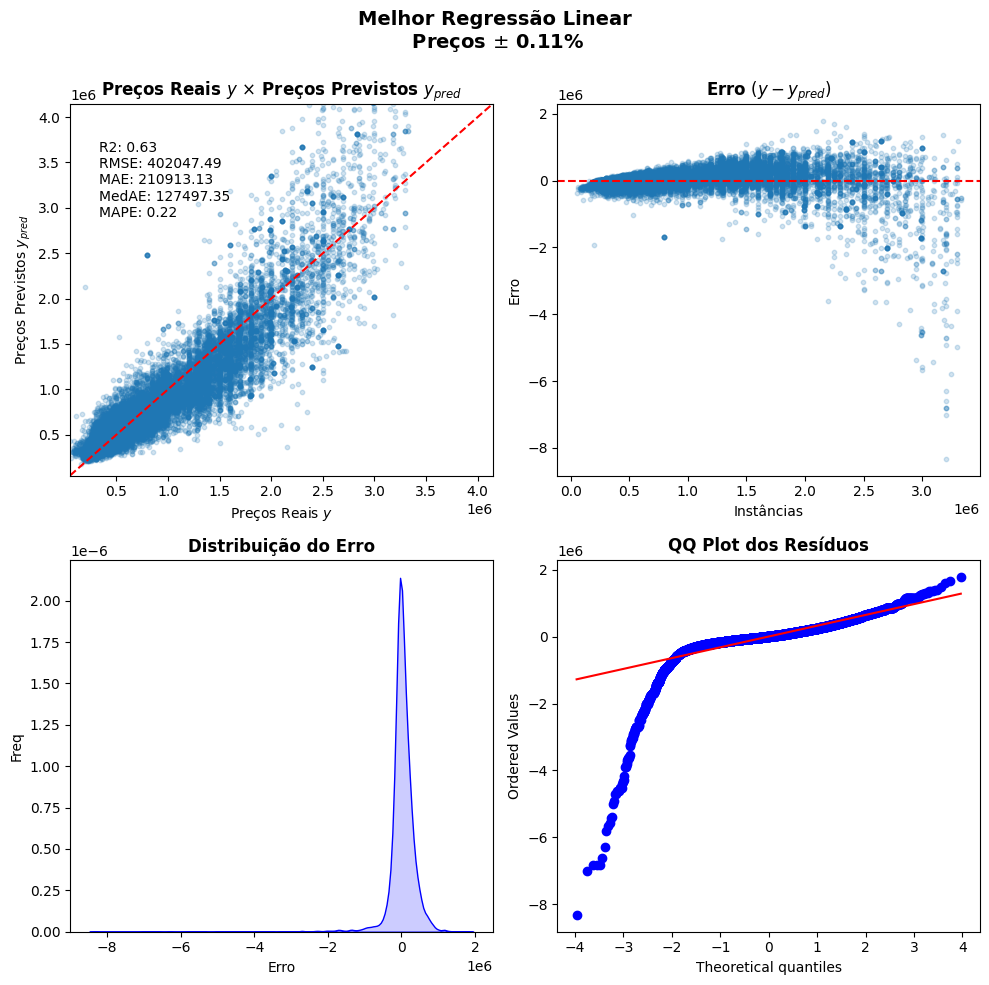

In [ ]:
plot_results(y_true, y_pred, 'Melhor Regressão Linear', qmax=0.99)

In [ ]:
latex_table = gera_df_stats_latex(results_df,'Results Linear Models')
display(Latex(latex_table))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Latex object>

In [ ]:
end_time = time.time()
execution_time = end_time - start_time

print(f"Tempo de execução: {execution_time/60:.2f} min")

Tempo de execução: 0.08 min


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Save results

In [ ]:
from google.colab import files

results_df.to_csv('imoveis_results_linear_regressions.csv', index=None)
files.download('imoveis_results_linear_regressions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>